# The present notebook contains code for the Titanic Kaggle challenge: [www.kaggle.com/c/titanic/](https://www.kaggle.com/c/titanic/)
The challenge consists in predicting the survival of the Titanic passengers.   
The data has been split into training and test data

    * Training: About 900 passengers whose survival is given.
    * Test: Over 400 passengers for whom we must predict the tragedy survival.   
## The problem is addressed using a Random Forest Classifier

---
## Importing libraries and modules

In [1]:
import numpy as np
import pandas as pd 
pd.options.mode.chained_assignment = None
# so that we do not receive warnings every time
# we overwrite dataframes 
import seaborn as sb 
from itertools import compress 
import time
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

from sklearn.ensemble import RandomForestClassifier as rfc
from sklearn.decomposition import PCA

## Upload the data

In [2]:
import os
path = os.getcwd()
df_train = pd.read_csv(path+'/train.csv')
df_test = pd.read_csv(path+'/test.csv')

## Having a quick look at the data 

In [3]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Survival rate by sex

In [7]:
df_train.groupby(['Sex','Survived']).Survived.count()*100 / df_train.groupby(['Sex']).Sex.count()

Sex     Survived
female  0           25.796178
        1           74.203822
male    0           81.109185
        1           18.890815
dtype: float64

## Survival rate by class

In [8]:
df_train.groupby(['Pclass','Survived']).Survived.count()*100 / df_train.groupby(['Pclass']).Pclass.count()

Pclass  Survived
1       0           37.037037
        1           62.962963
2       0           52.717391
        1           47.282609
3       0           75.763747
        1           24.236253
dtype: float64

## Unique values and frequency in 'Cabin' column

In [9]:
df = pd.DataFrame({'Unique' : df_train['Cabin'][df_train.Cabin.notnull()].unique()})
df['Count'] = np.zeros(df.shape[0])
for i in range(df.shape[0]):
    df['Count'][i] = (df_train['Cabin'] == df['Unique'][i]).sum()

cab = df['Unique'][np.argmax(df['Count'])]
print('Most common cabin type : '+cab)

Most common cabin type : G6


## Unique values and frequency in 'Embarked' column 

/Users/daviddiegocastro/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


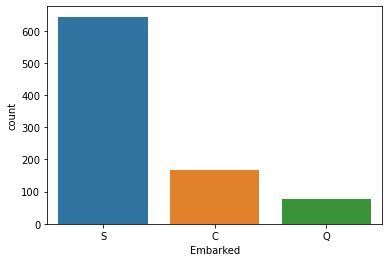

In [10]:
sb.countplot('Embarked', data = df_train)
plt.show() 

---
# CLEANING THE DATA
## Issues:

* The data contain NaN values (both training and set)

### Dealing with NaN values in 'Age' columns
We will set the missing values to the average value

In [11]:
df_train['Age'][df_train.loc[:,'Age'].isnull()] = df_train['Age'].mean()
df_test['Age'][df_test.loc[:,'Age'].isnull()] = df_test['Age'].mean()

### Dealing with NaN values in 'Cabin' columns
The most common cabin type, that is: 'G6'

In [12]:
df_train['Cabin'][df_train.loc[:,'Cabin'].isnull()] = 'G6'
df_test['Cabin'][df_test.loc[:,'Cabin'].isnull()] = 'G6'

### Dealing with NaN values in 'Embarked' column (training set)
The most common embarking harbour: 'S'

In [13]:
df_train['Embarked'][df_train.loc[:,'Embarked'].isnull()] = 'S'

### Dealing with NaN values in 'Fare' column (test set)
We will set the missing values to the average value

In [14]:
df_test['Fare'][df_test.loc[:,'Fare'].isnull()] = df_test['Fare'].mean() 

## Check data is cleaned

In [15]:
df_train.isnull().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [16]:
df_test.isnull().sum() 

PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

---
## Applying bag-of-words approach to convert strings into integers.

* We will exclude the 'Name' column. It is redundant with respect to 'PassengerId' 
* Also, the column 'Ticket' contain nearly as many different elements as entries (so it does not provide relevant new information)

In [17]:
frac_ticket_train = len(df_train['Ticket'].unique()) / df_train.shape[0]
frac_ticket_test = len(df_test['Ticket'].unique()) / df_test.shape[0]
frac_cabin_train = len(df_train['Cabin'].unique()) / df_train.shape[0]
frac_cabin_test = len(df_test['Cabin'].unique()) / df_test.shape[0]
frac_emb_train = len(df_train['Embarked'].unique()) / df_train.shape[0]
frac_emb_test = len(df_test['Embarked'].unique()) / df_test.shape[0]

print("Fraction of different values in Train.Ticket column: {:.2f}".format(frac_ticket_train))
print("Fraction of different values in Test.Ticket column: {:.2f}\n".format(frac_ticket_test))
print("Fraction of different values in Train.Cabin column: {:.2f}".format(frac_cabin_train))
print("Fraction of different values in Test.Cabin column: {:.2f}\n".format(frac_cabin_test))
print("Fraction of different values in Train.Embarked column: {:.4f}".format(frac_emb_train))
print("Fraction of different values in Test.Embarked column: {:.4f}".format(frac_emb_test))

Fraction of different values in Train.Ticket column: 0.76
Fraction of different values in Test.Ticket column: 0.87

Fraction of different values in Train.Cabin column: 0.16
Fraction of different values in Test.Cabin column: 0.18

Fraction of different values in Train.Embarked column: 0.0034
Fraction of different values in Test.Embarked column: 0.0072


### Getting dictionaries from (relevant) string columns

In [18]:
str_cols = ['Sex','Cabin','Embarked']
bag_of_words = []
is_test_in_train = []
for col in str_cols:
    bow = {}
    words = df_train[col].unique()
    for w in words:
        if w not in bow:
            bow[w] = len(bow)
    bag_of_words.append(bow)
    ## Check if the corresponding column in test data contains 
    ## no new element
    subset = True
    words = df_test[col].unique()
    for w in words:
        subset = min(subset , w in bow)
    is_test_in_train.append(subset)


print(is_test_in_train)

[True, False, True]


### Transforming strings into integers for the columns for which the test data does not contain any new element

In [19]:
cols = list(compress(str_cols , is_test_in_train))
bow = list(compress(bag_of_words , is_test_in_train))
for i in range(len(cols)):
    col = cols[i]
    for w,value in bow[i].items():
        df_train[col][df_train[col] == w] = value
        df_test[col][df_test[col] == w] = value 
    

### Dealing with string columns for which test data contain different elements

In [20]:
cols = list(compress(str_cols , np.logical_not(is_test_in_train)))
bow = list(compress(bag_of_words , np.logical_not(is_test_in_train)))
for i in range(len(cols)):
    col = cols[i]
    words = df_test[col].unique()
    for w in words:
        if w not in bow[i]:
            bow[i][w]=len(bow[i])
    
    for w,value in bow[i].items():
        df_train[col][df_train[col] == w] = value
        df_test[col][df_test[col] == w] = value


## Correlation between columns 

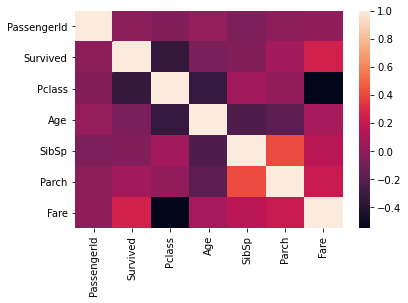

In [21]:
sb.heatmap(df_train.corr())
plt.show()

## The columns 'SibSp' and 'Parch' seem to be correlated. 
We may add them into a single column named 'Num_relatives'

In [22]:
df_train['Num_relatives'] = df_train['SibSp']+df_train['Parch']
df_test['Num_relatives'] = df_test['SibSp']+df_test['Parch']

---
## Extracting feature vectors representing Titanic passengers
Data will be labeled as:

    * x_train, x_test : numpy array of shape (n,feat_dim). Each row is a feature vector representing a passenger
    * y_train : numpy array of shape (n,). Each entry contains 1 if the passenger survived, 0 otherwise.

In [23]:
discarded_cols = ['Passenger_Id','Name','Ticket','Survived','SibSp','Parch']
selected_cols = list(set(list(df_train.columns)) - set(discarded_cols))

x_train = df_train[selected_cols].to_numpy().astype(float)
x_test = df_test[selected_cols].to_numpy().astype(float)
y_train = df_train['Survived'].to_numpy().astype(int)

### Normalize the data

In [24]:
x_train = x_train / x_train.max(axis=0)
x_test = x_test / x_test.max(axis=0)

---
## Dimensionality reduction and data visualization

### Applying PCA to feature vectors

In [25]:
pca = PCA(n_components=6)
# Centering the training data
x_cent = (x_train.T-x_train.mean(axis=1)).T
pca.fit(x_cent)
# Extract the PC of the centered data
pcx_train = pca.transform(x_cent)

# Centering the test data
x_cent = (x_test.T-x_test.mean(axis=1)).T
pca.fit(x_cent)
# Extract the PC of the centered data
pcx_test = pca.transform(x_cent)

### Visualizing the spatial distribution of data

In [26]:
def pc_plot(data,n_pc_comp=2):
    """
    Generates the scatter plot of the PCA transformed data
    Args:
        data : numpy array of shape (n_samples,dim_feature)
               Containd the PC decomposition of the (centered)
               original data
        n_pc_comp : integer. 
                    Number of principal components to plot
                    Default n_pc_comp = 2
    """
    
    if n_pc_comp not in [2,3]:
        n_pc_comp = 2
    
    title = 'Principal components of training feature vectors'
    
    plt.rc('xtick',labelsize = 15)
    plt.rc('ytick',labelsize = 15)
    
    color_green = df_train['Survived'].to_numpy() # survived
    color_red = np.logical_not(color_green) # did not survive 
    
    MS = 30 # Marker Size
    
    if n_pc_comp == 2:
        
        ## Plot data with label: did not survive 

        plt.scatter(data[color_red,0],data[color_red,1],
                  s=MS,c = 'r',marker = '.')

        ## Plot data with label: survived
        plt.scatter(data[color_green,0],data[color_green,1],
                  s=MS,c = 'g',marker = '.')

        plt.legend(['did not survive','survived'])

        plt.xlabel('pc1', fontsize=20)
        plt.ylabel('pc2', fontsize=20)
        plt.title(title,fontsize=20)
        plt.show()
    else:
        figsize = (30,30)
        fig = plt.figure()
        ax = Axes3D(fig)

        ## Plot data with label: did not survive
        ax.scatter(data[color_red,0],data[color_red,1],data[color_red,2],
                   c = 'r',marker = '.')

        ## Plot data with label: survived
        plt.scatter(data[color_green,0],data[color_green,1],data[color_green,2],
                    c = 'g',marker = '.')

        ax.legend(['did not survive','survived'])

        ax.set_xlabel('pc1', fontsize=20)
        ax.set_ylabel('pc2', fontsize=20)
        ax.set_zlabel('pc3', fontsize=20)
        ax.set_title(title,fontsize=20)
        plt.show()
    

### Plotting the first 2 PC

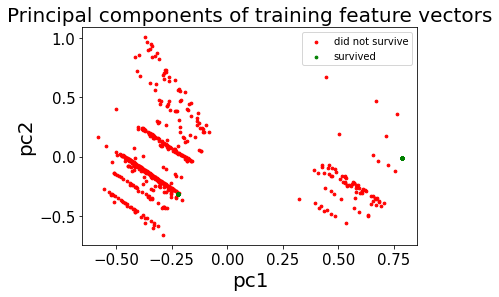

In [27]:
pc_plot(pcx_train)

### Plotting the first 3 PC

/Users/daviddiegocastro/opt/anaconda3/lib/python3.8/site-packages/matplotlib/collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


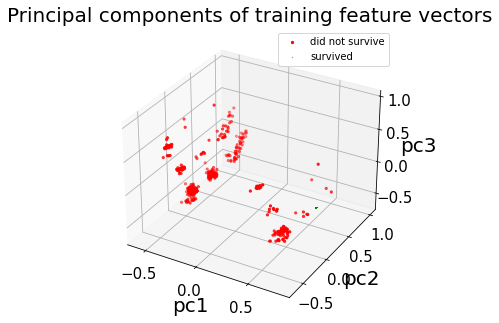

In [28]:
pc_plot(pcx_train,n_pc_comp=3)

---
# Fitting the data
We will use the non-linear classifier NuSVC() with the option weight_class = 'balanced'

## Parameter searching

### Set searching ranges

In [29]:
perm = np.arange(x_train.shape[0])
np.random.shuffle(perm)
split_index = int(x_train.shape[0])

### 1) Using the entire feature vector

In [30]:
## Obtain training sample

sample = x_train.copy()
y_sample = y_train.copy()
sample = sample[perm]
y_sample = y_sample[perm]

sample = sample[:split_index]
y_sample = y_sample[:split_index]

## Do the search

score_feat = []

tic = time.perf_counter()

clf = rfc(class_weight='balanced')
clf.fit(sample,y_sample)
score_feat = clf.score(sample, y_sample)
                   
toc = time.perf_counter()


print("Computation time: {:.2f} seconds".format(toc-tic))
print("\nFeat. vect. Corresponding score: {:.4f}".format(np.max(score_feat)))

Computation time: 0.17 seconds

Feat. vect. Corresponding score: 1.0000


### 2) Using dimensionality reduction (PCA)

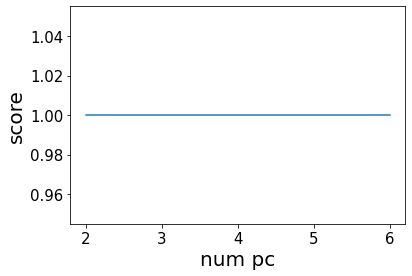

Computation time: 0.93 seconds

PCA. Best number of principal components: 2
PCA. Corresponfing highest score: 1.0000


In [31]:
## Obtain training sample

sample = pcx_train.copy()
y_sample = y_train.copy()
sample = sample[perm]
y_sample = y_sample[perm]

sample = sample[:split_index]
y_sample = y_sample[:split_index]

## Do the search 

n_comps = np.arange(2,7)
scores = []

tic = time.perf_counter()
for nc in n_comps:
    clf = rfc(class_weight='balanced')
    clf.fit(sample[:,:nc],y_sample)
    scores.append(clf.score(sample[:,:nc],y_sample))

toc = time.perf_counter()

best = np.argmax(scores) 
score_pca = scores[best]
best_n_comp = n_comps[best]


plt.rc('xtick',labelsize = 15)
plt.rc('ytick',labelsize = 15)


plt.plot(n_comps,scores)
plt.xlabel('num pc',fontsize=20)
plt.ylabel('score',fontsize=20)
plt.show()

print("Computation time: {:.2f} seconds".format(toc-tic))
print("\nPCA. Best number of principal components: {}".format(best_n_comp))
print("PCA. Corresponfing highest score: {:.4f}".format(score_pca))

## Setting the nu-parameter and the method
The options for the method are: 
* method = 'feat'
    * The fitting is preformed on the whole feature vector
* method = 'pca'
    * The fitting is preformed on the PCA reduction
    * n_pc : Number of principal components to use in the fit

In [32]:
scores = (score_feat , score_pca)
Method = ('feat','pca')

ind = np.argmax(scores)
method = Method[ind]
n_pc = best_n_comp

### Extracting training sample

In [33]:
def extract_sample(sample_size, method = method, n_pc = n_pc):
    """
    Extracts a sample from the training data
    
    Args:
        sample_size : integer. The size of the sample
        method : string. If method = 'feat' : extracts sample from x_train
                         If method = 'pca' : extracts sample from the pcx_train
        n_pc : integer. Number of principal components to use
                        when method = 'pca'
                         
    Returns:
        tuple : (sample , y_sample)
                sample : 2d numpy array containing the training sample
                y_sample : 1d numpy array containing the corresponding labels
                 
    """
    ## Get a copy of the suitable data according the method
    if method == 'feat':
        sample = x_train.copy()
    else:
        sample = pcx_train[:,:n_pc].copy()
    
    y_sample = y_train.copy()
    
    ## Get a permutation of the training feature vector indices
    perm = np.arange(x_train.shape[0])
    np.random.shuffle(perm)
    
    ## Sample the data
    sample = sample[perm]
    y_sample = y_sample[perm]

    sample = sample[:sample_size]
    y_sample = y_sample[:sample_size]
    
    return sample, y_sample 

### Fitting the model

In [34]:
def fit_data(sample_size, method=method,
             n_pc=n_pc):
    """
    Fits the data using the NuSVC classifier, using
    RBF as kernel
    
    Args:
        sample_size : integer. Size of the training sample 
        nu : float. nu-parameter for the NuSVC classifier
        method : string. method for extracting the training sample
        n_pc : integer. Number of principal components to use
                        when method = 'pca'
    Returns:
        clf :         the fitted classifier
        predictions : numpy array of shape (n_bookings ,)
                      Contains the extra baggage predictions
                      for the test data
    """
    
    ## Extract the sample
    sample, y_sample = extract_sample(sample_size,
                                    method = method, n_pc = n_pc)
    
    ## Do the fitting

    clf = rfc(class_weight = 'balanced')
    clf.fit(sample,y_sample)

    ## Obtain predictions for the test data

    if method == 'feat':
        predictions = clf.predict(x_test)
    else:
        predictions = clf.predict(pcx_test[:,:n_pc])
    
    ## Compute the score over the training sample 
    accuracy = clf.score(sample,y_sample)
    toc = time.perf_counter()
  
    
    print("The accuracy score on the training sample is: {:.2f}".format(accuracy))
    
    return clf, predictions  

### Randomly select a sample of 450 passengers from the training set and fit the data.
    * This reduced training sample has similatr size to that of the test sample.
    * This allows us to validate the fitting by applying it to a randomly selected new sample of similar size. 

In [35]:
clf, predictions = fit_data(int(x_train.shape[0]/2))

The accuracy score on the training sample is: 1.00


## Validate the fitting. 

* Apply the fitted classifier to another (randomly selected) sample from the training set:
* This will give us an idea of the performance of the fitting on the test set.

In [36]:
## Extract the sample
sample, y_sample = extract_sample(int(x_train.shape[0]/2))

## Compute the score over the new train sample  

accuracy = clf.score(sample,y_sample)

print("The accuracy score on the new sample is: {:.2f}".format(accuracy))

The accuracy score on the new sample is: 0.90


---
# Generating the predictions

In [37]:
sur_predictions = pd.DataFrame(df_test['PassengerId']) 
sur_predictions['Survived'] = predictions
#sur_predictions.to_csv(path_or_buf='Survival_predictions_RFC.csv',index=False)